Energy: -37.83809823961611
Entanglement Entropy:  [0.3362777355455277, 0.3742559142820449, 0.3998235832071532, 0.41866056062531015, 0.43322026104508216, 0.44477307181210907, 0.45405568797568463, 0.4615287838768125, 0.46749539063600193, 0.4721611960690695, 0.4756676294250908, 0.47811095812722304, 0.47955359272073034, 0.480030685173592, 0.4795535929785567, 0.478110958314097, 0.4756676295454255, 0.4721611961327464, 0.4674953906555043, 0.4615287838766517, 0.4540556879632444, 0.4447730718050791, 0.4332202610396072, 0.41866056062202434, 0.3998235832045295, 0.37425591427992416, 0.33627773554426627]


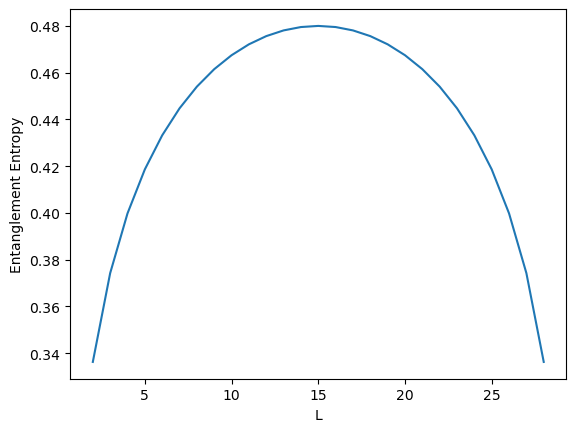

In [19]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code integrates the following concepts:
#  - Infinite system algorithm
#  - Finite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK

#matplotlib imports
import matplotlib.pyplot as plt

# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

# This function should test the same exact things, so there is no need to
# repeat its definition.
is_valid_enlarged_block = is_valid_block

# Model-specific code for the transverse field Ising model
model_d = 2  # single-site basis size
Pz1 = (-1.0)*np.array([[1, 0], [0, -1]], dtype= 'd')  #single-site Pauli z
N = 30
g = 1.0

# list to save the entanglement entropy values
EElist = []

#list to save corresponding length of system
syslist = []

H1 = (-1.0)*g*np.array([[0, 1], [1, 0]], dtype= 'd')  #single-site portion of H is single-site Pauli x

def H2(Pz1,Pz2):  # two-site part of H
    """Given pauli-z matrices on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """    
    return (kron(Pz1,Pz2))

# conn refers to the connection operator, that is, the operator on the edge of
# the block, on the interior of the chain. 
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Pz": Pz1,
})

def enlarge_block(block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Pz"], Pz1),
        "conn_Pz": kron(identity(mblock), Pz1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

def single_dmrg_step(sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Pz"], env_enl_op["conn_Pz"])

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    # Entanglement_entropy S = -\sum_\alpha s_\alpha^2 \log s_\alpha^2
    Entanglement_entropy = -np.sum(evals*(np.log(np.abs(evals))))
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy, Entanglement_entropy

def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

def infinite_system_algorithm(L, m):
    block = initial_block
    # Repeatedly enlarge the system by performing a single DMRG step, using a
    # reflection of the current block as the environment.
    while 2 * block.length < L:
        print("L =", block.length * 2 + 2)
        block, energy, Entanglement_entropy = single_dmrg_step(block, block, m=m)
        print("E/L =", energy / (block.length * 2))

def finite_system_algorithm(L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects
  
    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        block, energy, Entanglement_entropy = single_dmrg_step(block, block, m=m_warmup)
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block
            
    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            sys_block, energy, Entanglement_entropy = single_dmrg_step(sys_block, env_block, m=m)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block
            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                print("Energy:",energy)
                for m in m_sweep_list:
                    while True:
                        # Load the appropriate environment block from "disk"
                        env_block = block_disk[env_label, L - sys_block.length - 2]
                        if env_block.length == 1:
                            # We've come to the end of the chain, so we reverse course.
                            sys_block, env_block = env_block, sys_block
                            sys_label, env_label = env_label, sys_label
                        
                        # Perform a single DMRG step.
                        sys_block, energy, Entanglement_entropy = single_dmrg_step(sys_block, env_block, m=m)
                        if sys_label == "l":
                            L_length = sys_block.length                          
                        else:
                            L_length = L - sys_block.length
                        syslist.append(L_length)
                        EElist.append(Entanglement_entropy)
                        # Save the block from this step to disk.
                        block_disk[sys_label, sys_block.length] = sys_block
                        # Check whether we just completed a full sweep.
                        if sys_label == "l" and 2 * sys_block.length   == L:
                            break  # escape from the small "while True" loop
                break  # escape from the big "while True" loop
                           
                

if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
    finite_system_algorithm(L=30, m_warmup=16, m_sweep_list=[16])

#print entanglement entropy and plot S(L)

#make slices of EElist and syslist, so that syslist is from 2 to 28 and EElist has the corresponding entanglement entropies
EElist = EElist[:int((N-4)/2)]+ EElist[-int((N-2)/2):]
syslist = syslist[:int((N-4)/2)]+ syslist[-int((N-2)/2):]

#using argsort to find the order
order = np.argsort(syslist)
EElist_ordered = [EElist[order[i]] for i in range(len(order))]
syslist_ordered = [syslist[order[i]] for i in range(len(order))]

print("Entanglement Entropy: ",EElist_ordered)

#plot the figure
plt.plot(syslist_ordered,EElist_ordered)
plt.xlabel('L')
plt.ylabel('Entanglement Entropy')
plt.show()